In [ ]:
!pip install meteostat

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.stats as st
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from meteostat import Point, Daily
from datetime import datetime
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
def dateFormat(df):
  # combine the Year, Month and Day into Date column for model training
  df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
  # and drop Year, Month and Day column
  df = df.drop(columns=['Year', 'Month', 'Day'])
  # Ensure sorting by time
  df = df.sort_values('Date')
  # To make sure Date column is the first
  cols = list(df.columns)
  new_order = ['Date'] + [c for c in cols if c != 'Date']
  df = df[new_order]
  return df


In [ ]:
def processC(df):
  # Transfer Data Completeness column if C to 1 else 0
  df['Data Completeness'] = df['Data Completeness'].apply(lambda x: 1 if x == "C" else x)

In [ ]:
def dropNa(df):
  # turn the *** to Nan
  df['Value'] = df['Value'].replace(['***','NaN','nan','',' '], np.nan)
  # transfer the data type to float from object
  df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
  # using fill and linear to handle missing value in Value and Data Completeness column
  df['Value'] = df['Value'].fillna(method='ffill')
  df['Value'] = df['Value'].interpolate(method='linear')
  df['Data Completeness'] = df['Data Completeness'].fillna(method='ffill')

In [ ]:
# data preparation function
def dataPreparation(df):
  dropNa(df)
  dateFormat(df)
  processC(df)



In [ ]:
# the create sequences function
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])   # the X take data for a consecutive window_size days as the input sequence.
        y.append(data[i+window_size])     # the y take the data from the next window_size+1 days after this sequence as the prediction target.
    return np.array(X), np.array(y)



In [ ]:
def createRNNModel(X_train, y_train, X_test, y_test, windowSize):
    model = Sequential()
    model.add(SimpleRNN(100, input_shape=(windowSize, 1), activation='relu', return_sequences=True))
    model.add(SimpleRNN(100, activation='relu', return_sequences=False))
    model.add(Dense(1))

    # stop_early = EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     min_delta=1e-4,
    #     mode='min',
    #     restore_best_weights=True
    # )

    model.compile(optimizer='adam', loss='mse',
                  metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    title = 'RNN model: actual vs. predicted temperatures'
    plot(X_test, y_test, model, y_pred, title)

    # Return a one-dimensional error vector
    errors = (y_test.ravel() - y_pred.ravel())
    return errors


In [ ]:
def creatLSTMModel(X_train, y_train, X_test, y_test, windowSize):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(windowSize, 1), dropout=0.2))
    model.add(LSTM(units=100, dropout=0.2, return_sequences=False))
    model.add(Dense(1))

    # stop_early = EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     min_delta=1e-4,
    #     mode='min',
    #     restore_best_weights=True
    # )

    model.compile(optimizer='adam', loss='mse',
                  metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    title = 'LSTM model: actual vs. predicted temperatures'
    plot(X_test, y_test, model, y_pred, title)

    # Return a one-dimensional error vector
    errors = (y_test.ravel() - y_pred.ravel())
    return errors

In [ ]:
#Function used to plot the error distribution between RNN and LSTM models
def errorDistributions(rnnErrors, lstmErrors):
  plt.figure(figsize=(10,5))
  plt.hist(rnnErrors, bins=30, alpha=0.5, label='RNN Errors', color='blue')
  plt.hist(lstmErrors, bins=30, alpha=0.5, label='LSTM Errors', color='orange')
  plt.xlabel('Error (°C)')
  plt.ylabel('Frequency')
  plt.title('Error Distributions: RNN vs LSTM')
  plt.legend()
  plt.show()

In [ ]:
#Plot predict and actual temperatures
def plot(X_test, y_test, model, y_pred, title):

  plt.figure(figsize=(12,6))
  plt.plot(y_test, label='True Values', color='blue')
  plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Temperature')
  plt.legend()
  plt.show()



In [ ]:
def trainData(trainDataSet, testDataSet, window_size):
  #  create sequences use a window of 30–60 past days to predict the next day
  X_train, y_train = create_sequences(trainDataSet['Value'].values, window_size)
  X_test, y_test   = create_sequences(testDataSet['Value'].values, window_size)

  # RNN/LSTM required input shape (samples, timesteps, features)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  #Normalize training data
  normalize = layers.Normalization()
  normalize.adapt(X_train)

  X_train = normalize(X_train)
  X_test  = normalize(X_test)

  return X_train, y_train, X_test, y_test

In [ ]:
#read csv file
testDataset = pd.read_csv('/content/daily_HKO_GMT_2025.csv', names = ['Year', 'Month', 'Day', 'Value', 'Data Completeness'], skiprows = 3, skipfooter=3)
trainDataset = pd.read_csv('/content/daily_HKO_GMT_ALL.csv', names = ['Year', 'Month', 'Day', 'Value', 'Data Completeness'], skiprows = 3, skipfooter=3)
dataPreparation(testDataset)
dataPreparation(trainDataset)
testDataset = dateFormat(testDataset)
trainDataset = dateFormat(trainDataset)
X_train, y_train, X_test, y_test = trainData(trainDataset, testDataset, 60)



Epoch 1/50


659/659 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 60.1308 - mean_absolute_error: 4.6476 - root_mean_squared_error: 6.9313 - val_loss: 2.9454 - val_mean_absolute_error: 1.3818 - val_root_mean_squared_error: 1.7162
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 3.8432 - mean_absolute_error: 1.4991 - root_mean_squared_error: 1.9596 - val_loss: 2.1360 - val_mean_absolute_error: 1.0580 - val_root_mean_squared_error: 1.4615
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 2.9630 - mean_absolute_error: 1.2955 - root_mean_squared_error: 1.7208 - val_loss: 2.8411 - val_mean_absolute_error: 1.3347 - val_root_mean_squared_error: 1.6856
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 2.9199 - mean_absolute_error: 1.2955 - root_mean_squared_error: 1.7083 - val_loss: 1.6372 - val_mean_absolute_error: 0.9164 - val_root_mean_squared_error: 1.2795
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 2.7591 - mean_absolute_error: 1.2393 - root_mean_squ

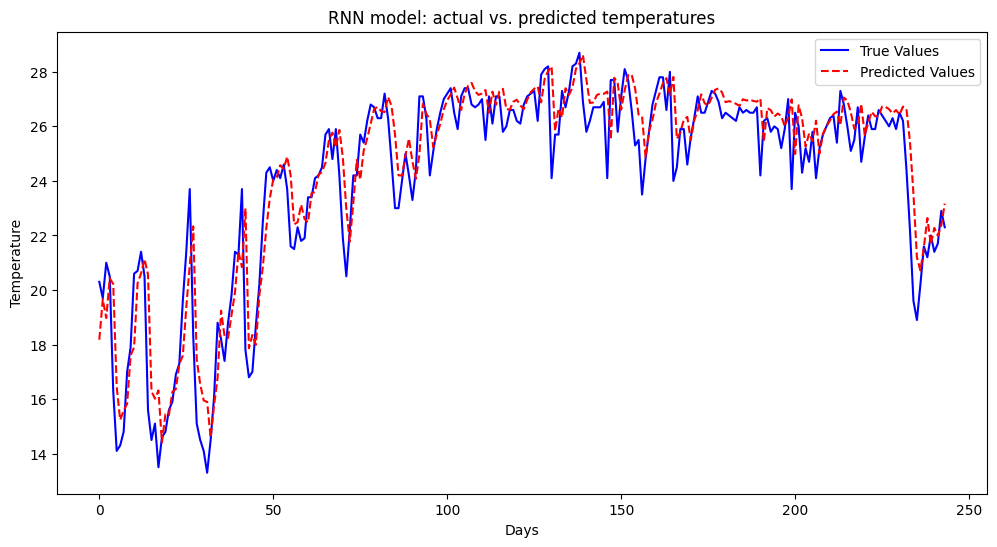

In [ ]:
rnnErrors = createRNNModel(X_train, y_train, X_test, y_test, 60)

Epoch 1/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - loss: 82.4401 - mean_absolute_error: 7.0438 - root_mean_squared_error: 8.5534 - val_loss: 4.6723 - val_mean_absolute_error: 1.8508 - val_root_mean_squared_error: 2.1615
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 9.1090 - mean_absolute_error: 2.1296 - root_mean_squared_error: 3.0176 - val_loss: 2.4475 - val_mean_absolute_error: 1.3009 - val_root_mean_squared_error: 1.5645
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - loss: 8.3236 - mean_absolute_error: 1.9426 - root_mean_squared_error: 2.8839 - val_loss: 2.8539 - val_mean_absolute_error: 1.4766 - val_root_mean_squared_error: 1.6894
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - loss: 8.0596 - mean_absolute_error: 1.8921 - root_mean_squared_error: 2.8387 - val_loss: 2.8748 - val_mean_absolute_error: 1.4803 - val_root_mean_squared_error: 1.6955
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - loss: 8.0485 - mean_absolute_error: 1.8937 - ro

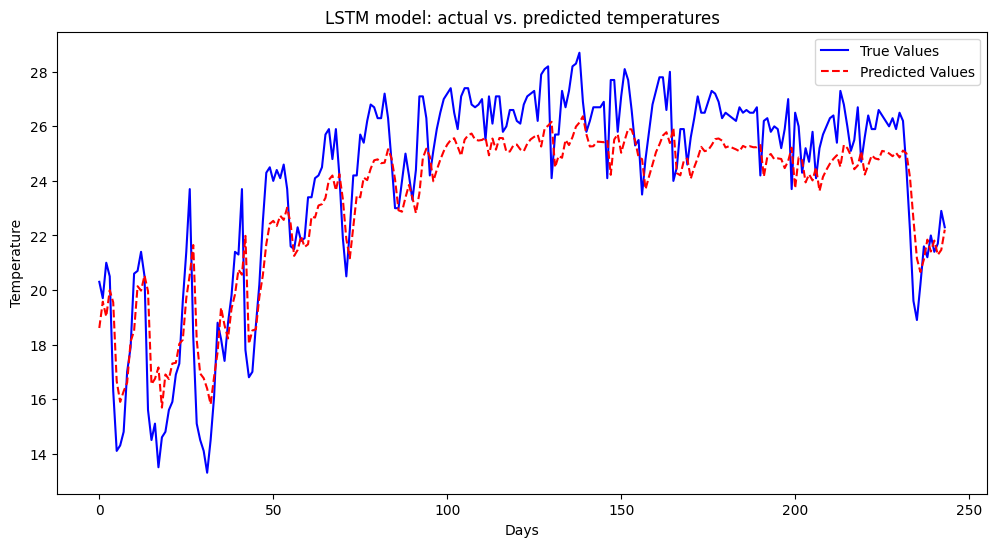

In [ ]:
lstmErrors = creatLSTMModel(X_train, y_train, X_test, y_test, 60)

In [ ]:
print(rnnErrors.shape, lstmErrors.shape)


(244,) (244,)


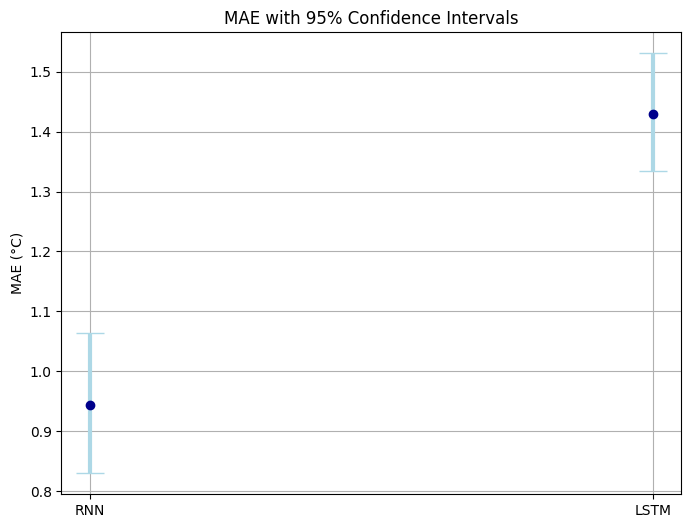

In [ ]:
def bootstrap_ci(errors, metric_fn, n_boot=1000, alpha=0.05):
    stats_list = []
    for _ in range(n_boot):
        #Random sampling from the error
        sample = np.random.choice(errors, size=len(errors), replace=True)
        #Calculate the statistic for this sampling.
        stats_list.append(metric_fn(sample))
    #Use percentiles as the confidence interval
    lower = np.percentile(stats_list, 100*alpha/2)
    upper = np.percentile(stats_list, 100*(1-alpha/2))
    return lower, upper
#Calculate the MAE of RNN and LSTM
mae_rnn = np.mean(np.abs(rnnErrors))
mae_lstm = np.mean(np.abs(lstmErrors))

ci_rnn = bootstrap_ci(rnnErrors, lambda e: np.mean(np.abs(e)))
ci_lstm = bootstrap_ci(lstmErrors, lambda e: np.mean(np.abs(e)))

models = ['RNN', 'LSTM']

# MAE Central Value
maes = [mae_rnn, mae_lstm]

# Trust interval upper and lower limits
ci_lows = [ci_rnn[0], ci_lstm[0]]
ci_highs = [ci_rnn[1], ci_lstm[1]]

# Calculate the error range
yerr_lower = np.array(maes) - np.array(ci_lows)
yerr_upper = np.array(ci_highs) - np.array(maes)

plt.figure(figsize=(8,6))
plt.errorbar(models, maes, yerr=[yerr_lower, yerr_upper],
             fmt='o', capsize=10, color='darkblue',
             ecolor='lightblue', elinewidth=3)

plt.ylabel('MAE (°C)')
plt.title('MAE with 95% Confidence Intervals')
plt.grid(True)
plt.show()

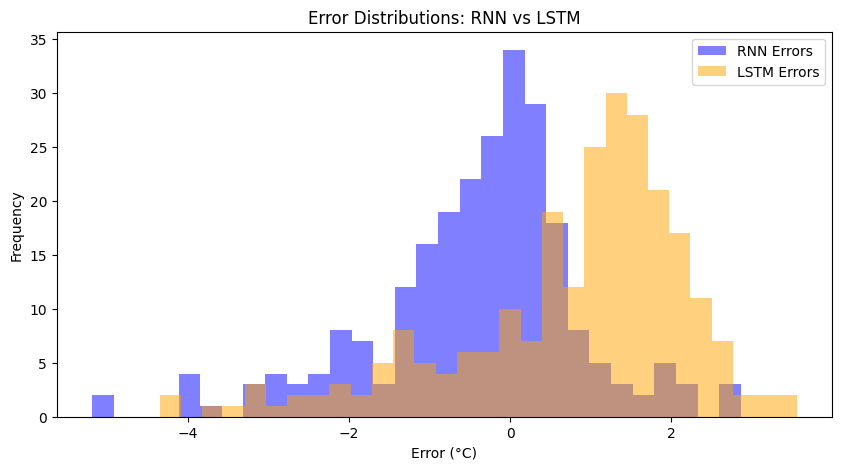

In [ ]:
errorDistributions(rnnErrors, lstmErrors)

Trial 24 Complete [00h 02m 59s]
val_loss: 7.73912239074707

Best val_loss So Far: 1.9324333667755127
Total elapsed time: 00h 37m 16s
Best units: 32, Best LR: 0.01
Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 69.7944 - mae: 6.2490 - root_mean_squared_error: 7.8064 - val_loss: 2.1892 - val_mae: 1.1098 - val_root_mean_squared_error: 1.4796
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.7485 - mae: 1.2066 - root_mean_squared_error: 1.6575 - val_loss: 1.9981 - val_mae: 1.0993 - val_root_mean_squared_error: 1.4136
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 2.6510 - mae: 1.1729 - root_mean_squared_error: 1.6277 - val_loss: 2.1710 - val_mae: 1.1741 - val_root_mean_squared_error: 1.4734
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 2.6100 - mae: 1.1766 - root_mean_squared_error: 1.6155 - val_loss: 2.0218 - val_mae: 1.0495 - val_root_mean_squared_error: 1.4219
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 2.5787

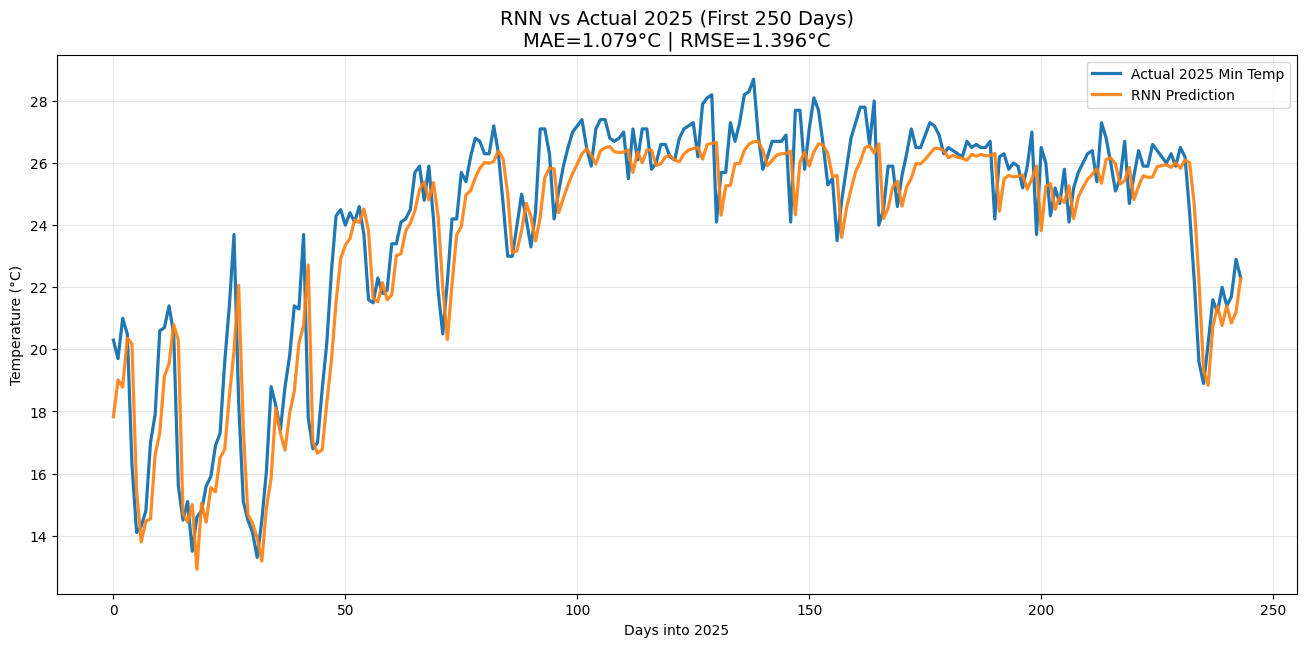

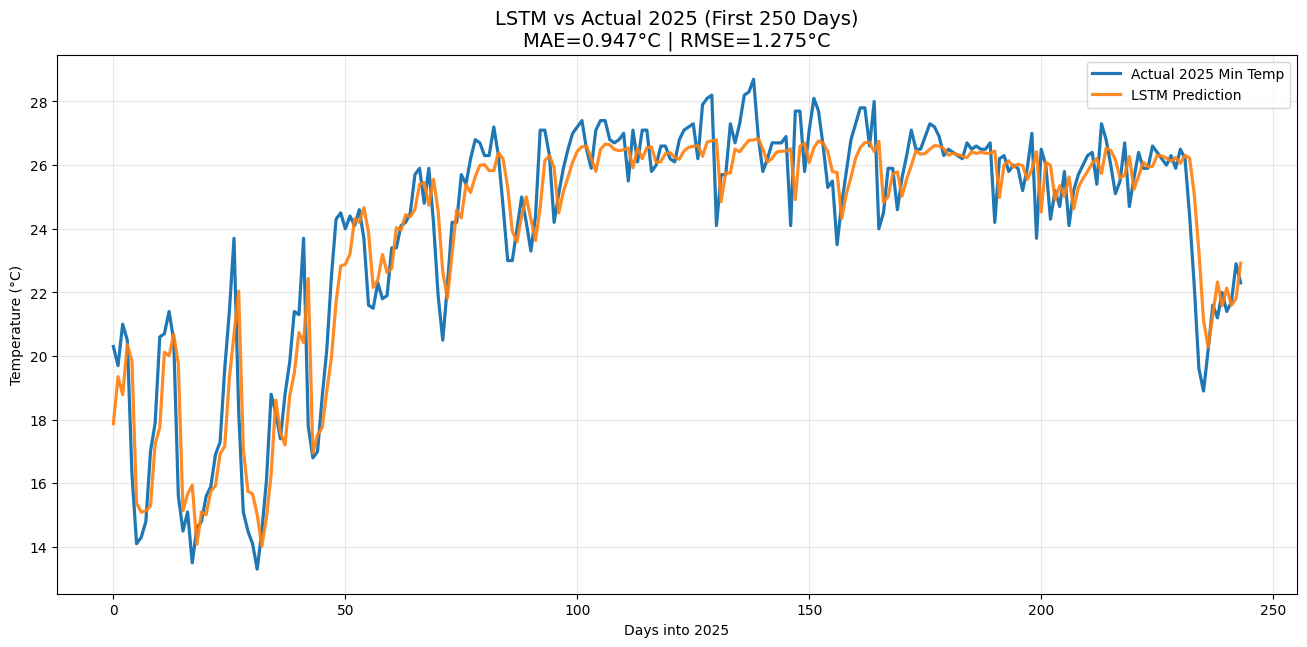

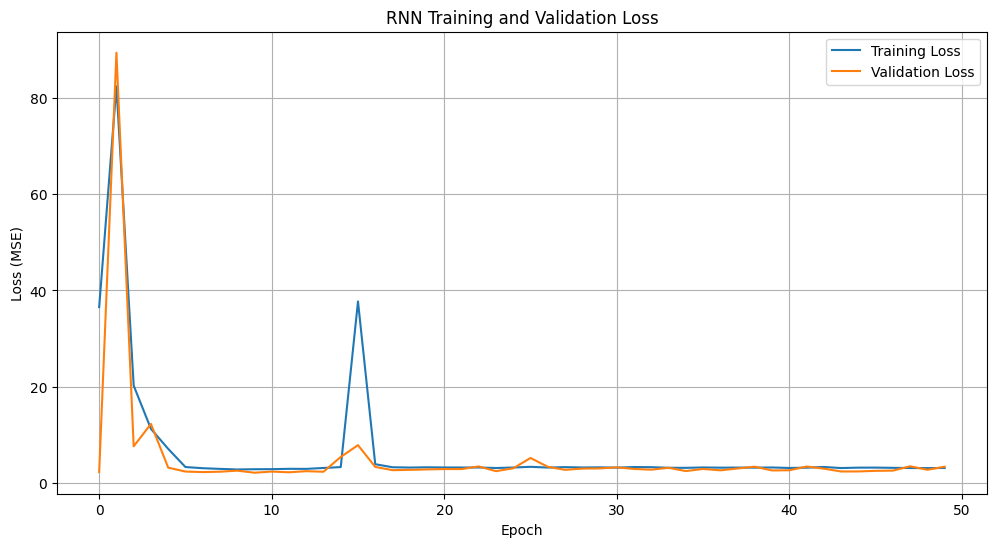

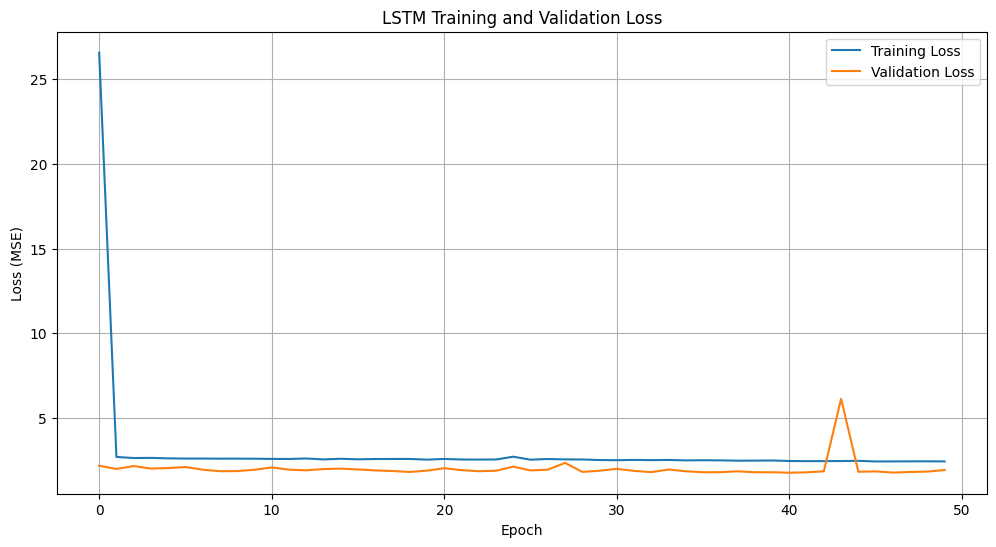

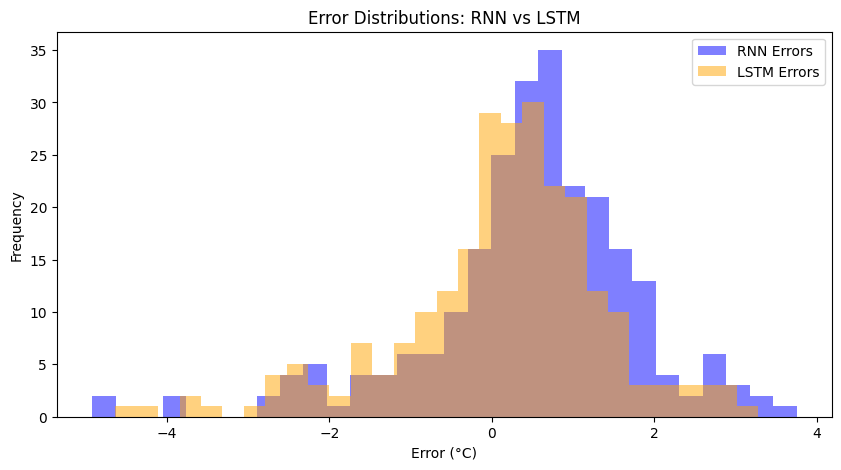

RNN MAE: 1.0794451400881906 95% CI: (np.float64(0.9736706450337268), np.float64(1.1842540340931689))
LSTM MAE: 0.9466028166598961 95% CI: (np.float64(0.8311688526927448), np.float64(1.0512253279177868))


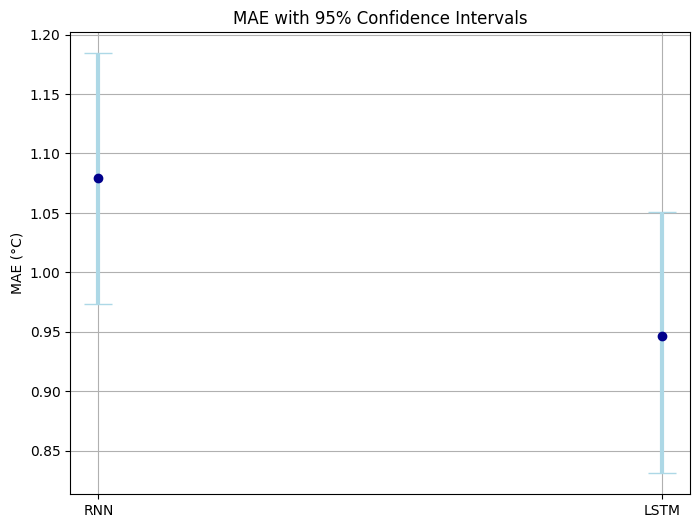

In [ ]:


# Model building function
def buildRNNModel(hp, windowSize):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(keras.layers.SimpleRNN(units=hp_units, input_shape=(windowSize,1)))
    model.add(keras.layers.Dense(1))
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='mse',
                  metrics=['mae', keras.metrics.RootMeanSquaredError()])
    return model

def buildLSTMModel(hp, windowSize):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(keras.layers.LSTM(units=hp_units, input_shape=(windowSize,1)))
    model.add(keras.layers.Dense(1))
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='mse',
                  metrics=['mae', keras.metrics.RootMeanSquaredError()])
    return model

# EarlyStopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# General experimental function
def run_experiment(build_fn, name, X_train, y_train, X_test, y_test, window_size=60):
    print(f"\n===== {name} EXPERIMENT =====")
    tuner = kt.Hyperband(
        lambda hp: build_fn(hp, window_size),
        objective='val_loss',
        max_epochs=50,
        factor=3,
        directory='model',
        project_name=f'{name.lower()}_temperature'
    )
    tuner.search(X_train, y_train, validation_split=0.2, callbacks=[stop_early])
    best_hp = tuner.get_best_hyperparameters()[0]
    print(f"Best units: {best_hp.get('units')}, Best LR: {best_hp.get('learning_rate')}")

    model = tuner.hypermodel.build(best_hp)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    print(f"Best epoch: {best_epoch}")

    final_model = tuner.hypermodel.build(best_hp)
    final_model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

    pred = final_model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} FINAL RESULT → MAE={mae:.3f}°C, RMSE={rmse:.3f}°C")

    return final_model, pred, history

#Error analysis tools
def bootstrap_ci(errors, metric_fn, n_boot=1000, alpha=0.05):
    stats = [metric_fn(np.random.choice(errors, size=len(errors), replace=True)) for _ in range(n_boot)]
    return np.percentile(stats, 100*alpha/2), np.percentile(stats, 100*(1-alpha/2))

def plot_prediction(y_true, y_pred, name):
    plt.figure(figsize=(16,7))
    plt.plot(y_true[:250], label="Actual 2025 Min Temp", linewidth=2.3)
    plt.plot(y_pred[:250], label=f"{name} Prediction", linewidth=2.3, alpha=0.9)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    plt.title(f"{name} vs Actual 2025 (First 250 Days)\nMAE={mae:.3f}°C | RMSE={rmse:.3f}°C", fontsize=14)
    plt.xlabel("Days into 2025")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_loss(history, name):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_error_distribution(errors_rnn, errors_lstm):
    plt.figure(figsize=(10,5))
    plt.hist(errors_rnn, bins=30, alpha=0.5, label='RNN Errors', color='blue')
    plt.hist(errors_lstm, bins=30, alpha=0.5, label='LSTM Errors', color='orange')
    plt.xlabel('Error (°C)')
    plt.ylabel('Frequency')
    plt.title('Error Distributions: RNN vs LSTM')
    plt.legend()
    plt.show()

def plot_mae_ci(mae_rnn, mae_lstm, ci_rnn, ci_lstm):
    models = ['RNN', 'LSTM']
    maes = [mae_rnn, mae_lstm]
    ci_lows = [ci_rnn[0], ci_lstm[0]]
    ci_highs = [ci_rnn[1], ci_lstm[1]]
    yerr_lower = np.array(maes) - np.array(ci_lows)
    yerr_upper = np.array(ci_highs) - np.array(maes)

    plt.figure(figsize=(8,6))
    plt.errorbar(models, maes, yerr=[yerr_lower, yerr_upper],
                 fmt='o', capsize=10, color='darkblue',
                 ecolor='lightblue', elinewidth=3)
    plt.ylabel('MAE (°C)')
    plt.title('MAE with 95% Confidence Intervals')
    plt.grid(True)
    plt.show()

#Execution of experiments
rnn_model, rnn_pred, rnn_history = run_experiment(buildRNNModel, "RNN", X_train, y_train, X_test, y_test)
lstm_model, lstm_pred, lstm_history = run_experiment(buildLSTMModel, "LSTM", X_train, y_train, X_test, y_test)

#Image and Statistical Analysis
plot_prediction(y_test, rnn_pred, "RNN")
plot_prediction(y_test, lstm_pred, "LSTM")
plot_loss(rnn_history, "RNN")
plot_loss(lstm_history, "LSTM")

errors_rnn = y_test.ravel() - rnn_pred.ravel()
errors_lstm = y_test.ravel() - lstm_pred.ravel()
plot_error_distribution(errors_rnn, errors_lstm)

mae_rnn = np.mean(np.abs(errors_rnn))
mae_lstm = np.mean(np.abs(errors_lstm))
ci_rnn = bootstrap_ci(errors_rnn, lambda e: np.mean(np.abs(e)))
ci_lstm = bootstrap_ci(errors_lstm, lambda e: np.mean(np.abs(e)))
print("RNN MAE:", mae_rnn, "95% CI:", ci_rnn)
print("LSTM MAE:", mae_lstm, "95% CI:", ci_lstm)

plot_mae_ci(mae_rnn, mae_lstm, ci_rnn, ci_lstm)
